## Let's train a DQN to play an atari game

![MsPackman](http://www.atarimania.com/2600/boxes/hi_res/ms_pac_man_silver_1987_cart_2.jpg)

Image from http://www.atarimania.com/game-atari-2600-vcs-ms-pac-man_7391.html

Here we will implement a depp Q-Network (DQN) - an approximate q-learning algorithm with experience replay and target networks.

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

The exercise is based on [this tutorial](https://github.com/yandexdataschool/Practical_RL/blob/coursera/week4_approx/dqn_atari_pytorch.ipynb) and uses parts of the code written by authors of the course [4].

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash
        
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/utils.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/framebuffer.py

    !touch .setup_complete

On cluster dependencies are pre-downloaded for you. If you run this code elsewhere, uncomment the lines below to download dependencies:

In [2]:
#!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/atari_wrappers.py
#!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/utils.py
#!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/replay_buffer.py
#!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/framebuffer.py

In [3]:
import random
import numpy as np
import torch
import utils
import torchvision

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing

In [5]:
ENV_NAME = 'MsPacmanNoFrameskip-v4'

Let's see what observations look like.

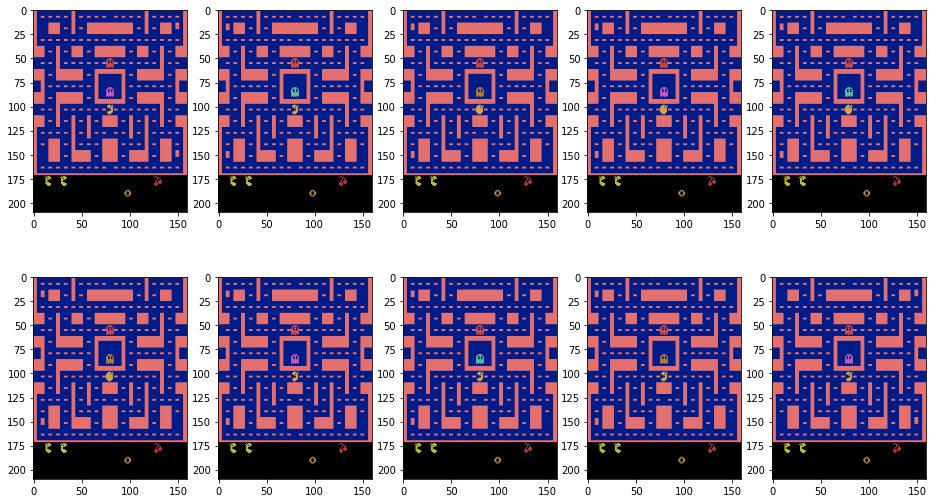

In [6]:
env = gym.make(ENV_NAME)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

In [7]:
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

Action space: Discrete(9)
Observation space: Box(0, 255, (210, 160, 3), uint8)


**Let's play a little.**

Pay attention to zoom and fps args of play function. 

In [8]:
# this will not work in the cloud environment (neither in colab nor in JSC cluster)

#from gym.utils.play import play

#play(env=gym.make(ENV_NAME), zoom=5, fps=30)

### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

Also please keep one dimension for channel so that final shape would be 1 x 64 x 64.

Tip: You can implement your own grayscale converter and assign a huge weight to the red channel. This dirty trick is not necessary but it will speed up learning.

In [10]:
# here I show you how it can be done with torchvision
# feel free to implement your own version and use other libraries
# e.g. opencv, skimage, PIL, ...

from gym.core import ObservationWrapper
from gym.spaces import Box
from torchvision.transforms.functional import to_grayscale, resize, to_tensor, to_pil_image

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        img = rgb*np.array(channel_weights).reshape(1, 1, 3)
        img = img*255/np.max(img)
        return(to_grayscale(img=to_pil_image(img.astype(np.uint8))))


    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img_crop = to_pil_image(img[1:176:2, ::2])
        img_resize = resize(img=img_crop, size=self.img_size[1:])
        img_gs = self._to_gray_scale(img_resize)

        return np.array(img_gs, dtype='float32').reshape(self.img_size)/np.max(img_gs)

Formal tests seem fine. Here's an example of what you'll get.


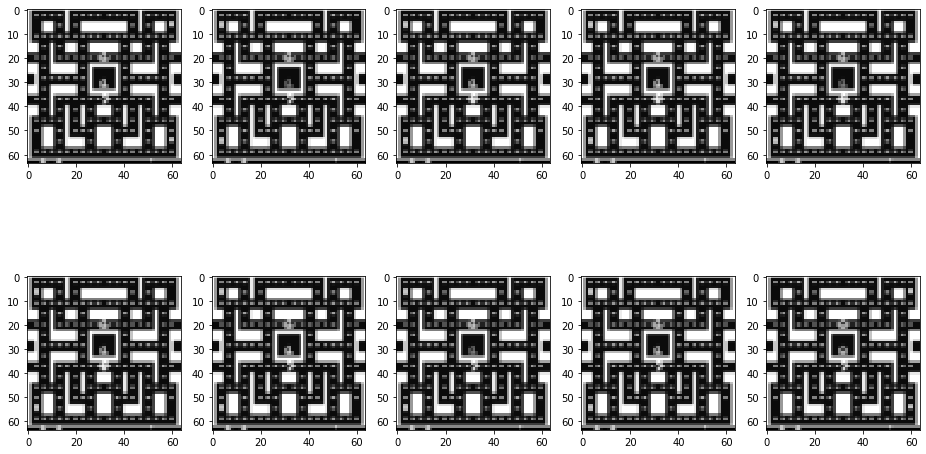

In [11]:
import gym
# spawn game instance for tests
env = gym.make(ENV_NAME)  # create raw env
env = PreprocessAtari(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"

assert np.max(obs) >= 0.5, "It would be easier to see a brighter observation"
assert np.mean(obs) >= 0.1, "It would be easier to see a brighter observation"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

### Wrapping.

**About the game:** 
The player earns points by eating pellets and avoiding monsters (contact with one causes Ms. Pac-Man to lose a life). Eating an energizer (or "power pellet") causes the monsters to turn blue, allowing them to be eaten for extra points. Bonus fruits can be eaten for increasing point values, twice per round. As the rounds increase, the speed increases, and energizers generally lessen the duration of the monsters' vulnerability, eventually stopping altogether ([source](https://en.wikipedia.org/wiki/Ms._Pac-Man)).

Here there are some common wrappers used for Atari environments.

In [12]:
%load_ext autoreload
%autoreload 2
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtari(env)
    return env

**Let's see if the game is still playable after applying the wrappers.**

In [12]:
# this will not work in the cloud environment (neither in colab nor in JSC cluster)

#from gym.utils.play import play

#def make_play_env():
#    env = gym.make(ENV_NAME)
#    env = PrimaryAtariWrap(env)
#    # in torch imgs have shape [c, h, w] instead of common [h, w, c]
#    env = atari_wrappers.AntiTorchWrapper(env)
#    return env

#play(make_play_env(), zoom=10, fps=3)

In [13]:
# let's see which actions are available
env.unwrapped.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. 

In [14]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

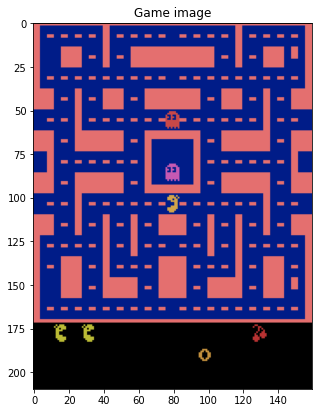

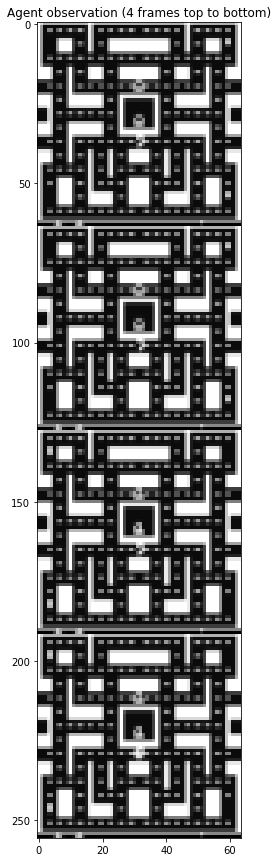

In [15]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[5,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[5,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

## DQN as it is

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png)

In [16]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [17]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [18]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Feel free to change the architecture
        self.features = nn.Sequential(
            nn.Conv2d(self.state_shape[0], 16, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 256),
            nn.ReLU(),
            nn.Linear(256, self.n_actions)
        )
        
    def feature_size(self):
        return self.features(torch.autograd.Variable(torch.zeros(1, *self.state_shape))).view(1, -1).size(1)

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        qvalues = self.features(state_t)
        qvalues = qvalues.view(qvalues.size(0), -1)
        qvalues = self.fc(qvalues)

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert len(qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        
        return np.where(should_explore, random_actions, best_actions)

In [19]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [20]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [21]:
evaluate(env, agent, n_games=5)

8.2

### Experience replay

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [22]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [24]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for step in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = qvalues.argmax(axis=-1)[0]
        s_next, r, done, _ = env.step(action)
        exp_replay.add(s, action, r, s_next, done)
        sum_rewards += r
        s = s_next
        
        if done:
            env.reset()

    return sum_rewards, s

In [25]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
print(len(exp_replay))
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [
        0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

1000
Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every $K$ steps.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [26]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [27]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss"""
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0] #<YOUR CODE>

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + is_not_done*gamma*next_state_values 

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [28]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

## Main loop


It's time to put everything together and see if it learns anything.

In [29]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [30]:
seed = 42 # your favourite random seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [31]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [32]:
exp_replay = ReplayBuffer(10**5)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [33]:
timesteps_per_epoch = 1
batch_size = 1024 if device.type == 'cuda' else 64  # if you run on JSC cluster
# batch_size = 32 # or 16 or 8 if you run on your local machine 
total_steps = 4 * 10**5  # 10**4 might be enough on cluster
decay_steps = 10**6 # you may wish to change it if you decrease the total_steps

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [34]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

buffer size = 100000, epsilon = 0.64000


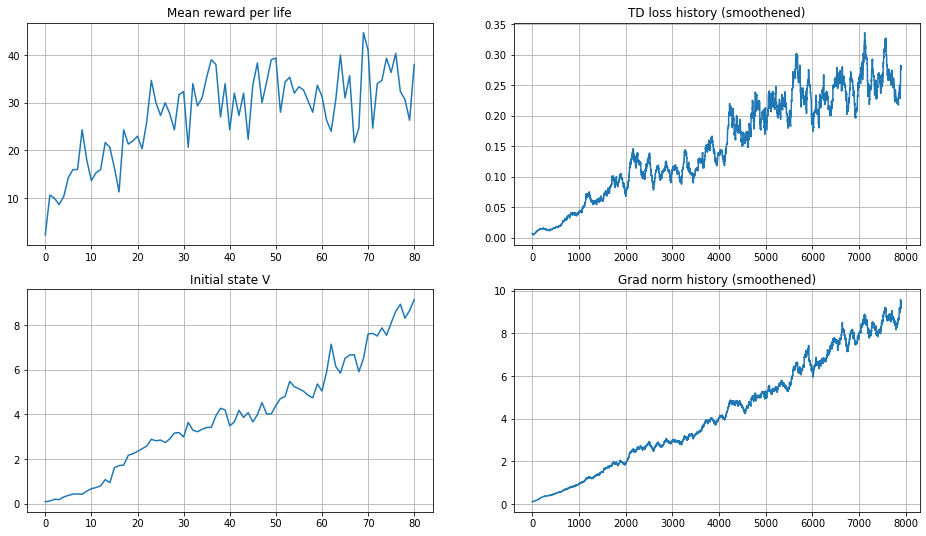

100%|██████████| 400001/400001 [1:15:09<00:00, 88.71it/s] 

CPU times: user 1h 14min 48s, sys: 27.3 s, total: 1h 15min 15s
Wall time: 1h 15min 9s


In [35]:
%%time
state = env.reset()
for step in trange(step, total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # sample batch_size of data from experience replay
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)

    # compute TD loss
    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, 
                           agent, target_network)  

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        if device.type=='cuda':
            plt.plot(utils.smoothen([g.cpu() for g in grad_norm_history]))
        else:
            plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()

Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. You can interrupt the learning after mean reward per life has reached at least 10.

**The goal is to get 100 points in the real env**. 

Final scoring is done on a whole episode with all 5 lives.

In [37]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score >= 100, 'not as cool as DQN can'
print('Cool!')

final score: 3033.333333333333
Cool!


## How to interpret plots:

This is not a supervised learning so don't expect anything to improve monotonously. 

* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or staying at exactly zero before agent has perfect performance.

* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.

* **mean reward** is the expected sum of $r(s,a)$ agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 

* In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.

* **Initial state V** is the expected discounted reward for episode in the opinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agent's overestimates.

* **buffer size** - this one is simple. It should go up and cap at max size.

* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.

* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to make more and more steps before it loses. Finally it will learn to actually score points.

**Training will take time.** On my machine it takes about an hour to get a reasonable result. On cluster (GPU) even better result can be achieved in a half an hour.

But hey, long training time isn't _that_ bad:
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)

## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low, but the performance is extremely poor.

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* batch size: This one can be very important: if it is too small the agent can fail to learn. Huge batch takes more time to process. This is not a problem for a JSC cluster, but if you will run this code on your local machine, take smaller batch_size (8 or 16 usually should be okay)

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow learning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.

* max_grad_norm - just huge enough. In torch clip_grad_norm also evaluates the norm before clipping and it can be convenient for logging.

### Video

In [36]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(20)]

In [38]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[0]))  # You can also try other indices

If the video is not recorded correctly, there is a bug in your version of `gym`. It is easy to fix that. You need to open a file `/path/to/gym/wrappers/monitoring/video_recorder.py` and edit this piece of code:

```python
def capture_frame(self, frame):
    if not isinstance(frame, (np.ndarray, np.generic)):
        raise error.InvalidFrame('Wrong type {} for {} (must be np.ndarray or np.generic)'.format(type(frame), frame))
    if frame.shape != self.frame_shape:
        raise error.InvalidFrame("Your frame has shape {}, but the VideoRecorder is configured for shape {}.".format(frame.shape, self.frame_shape))
    if frame.dtype != np.uint8:
        raise error.InvalidFrame("Your frame has data type {}, but we require uint8 (i.e. RGB values from 0-255).".format(frame.dtype))

        self.proc.stdin.write(frame.tobytes())
```

As you can see, the line `self.proc.stdin.write(frame.tobytes())` is never executed, there is an indentation error which needs to be corrected. After correction the code should look like this:

```python
def capture_frame(self, frame):
    if not isinstance(frame, (np.ndarray, np.generic)):
        raise error.InvalidFrame('Wrong type {} for {} (must be np.ndarray or np.generic)'.format(type(frame), frame))
    if frame.shape != self.frame_shape:
        raise error.InvalidFrame("Your frame has shape {}, but the VideoRecorder is configured for shape {}.".format(frame.shape, self.frame_shape))
    if frame.dtype != np.uint8:
        raise error.InvalidFrame("Your frame has data type {}, but we require uint8 (i.e. RGB values from 0-255).".format(frame.dtype))

    self.proc.stdin.write(frame.tobytes())
```

If you find it boaring to play with pre-implemented code, try to adjust the model for [other atari games](https://github.com/openai/gym/wiki/Table-of-environments).

## References

[[1]](http://incompleteideas.net/book/the-book.html) Richard S. Sutton and Andrew G. Barto, *Reinforcement Learning: An Introduction*,  MIT Press, Cambridge, MA, 2018

[[2]](https://www.guru99.com/reinforcement-learning-tutorial.html) Reinforcement Learning: What is, Algorithms, Applications, Example 

[[3]](https://gym.openai.com/docs/) Openai gym documentation

[[4]](https://github.com/yandexdataschool/Practical_RL) An open course on reinforcement learning. Taught by HSE University and Yandex School of Data Analysis (YSDA).

[[5]](https://www.coursera.org/learn/practical-rl) Coursera course on Practical RL

[[6]](https://arxiv.org/abs/1312.5602) Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou, Daan Wierstra, Martin Riedmiller, *Playing Atari with Deep Reinforcement Learning*,  arXiv:1312.5602v1

[[7]](https://www.davidsilver.uk/teaching/) David Silver, *Lectures on Reinforcement Learning*, 2015